In [1]:
%matplotlib inline                

<div style="float: left; vertical-align: middle; width: 100px; height: 100px;">
  <img src="Logos/NOAA_logo.png">
</div>
<div style="float: right; vertical-align: middle; width: 100px; height: 100px">
  <img src="Logos/NWS_logo.png">
</div>
<div style="text-align: center; vertical-align: top;">
  <span style="font-size: xx-large">
  Reading Scientific Datasets in Python<span>
  <br><br>
    <span style="font-size: xx-large">Todd Spindler</span><br><br>
  <span style="font-size: x-large">IMSG at NCEP/EMC<br>
  Verification Post Processing Product Generation Branch</span><br><br>
    <span style="font-size: x-large; font-style: italic;">Learn scientific data visualization in three easy&#42; lessons!</span><br><br><br>
    <span style="font-size: medium">&#42; and many more perhaps not-quite-so-easy lessons...</span>
</div>

## Just an FYI before we begin

- This entire presentation was created using Python 3 and Jupyter Notebooks

- All three example notebooks and the data sets are available from our web site:

    - http://polar.ncep.noaa.gov/ngmmf_python

- Feel free to download them and play with the notebooks

## Three commonly used binary dataset formats in use at EMC are (in no particular order):

- **NetCDF** (Network Common Data Format) 

- **GRIB** (GRIdded Binary or General Regularly-distributed Information in Binary form) 

- **BUFR** (Binary Universal Form for the Representation of meteorological data) 

## Example 1:  Reading a NetCDF data set

NetCDF can be read with any of the following libraries:
- **netCDF4-python** 

- **xarray** 

- **PyNIO**


In this example we'll use xarray to read a Global RTOFS NetCDF dataset, plot a parameter (SST), and select a subregion.

The xarray library can be installed via pip, conda (or whatever package manager comes with your Python installation), or distutils (python setup.py).

- Begin by importing the required libraries.

In [2]:
import matplotlib.pyplot as plt    # standard graphics library
import xarray
import cartopy.crs as ccrs         # cartographic coord reference system
import cartopy.feature as cfeature # features: land, borders, coastlines

- Open the file as an xarray Dataset and display the metadata.

In [3]:
dataset = xarray.open_dataset('rtofs_glo_2ds_n000_daily_prog.nc',
                              decode_times = True)

- `decode_times = True` will automatically decode the datetime values from NetCDF convention to Python datetime objects

- Note that this reads a local data set, but you can replace the filename with the URL of the corresponding NOMADS OpenDAP data set and continue without further changes.

In [4]:
dataset

<xarray.Dataset>
Dimensions:        (Layer: 1, MT: 1, X: 4500, Y: 3298)
Coordinates:
  * MT             (MT) datetime64[ns] 2018-08-26
    Date           (MT) float64 ...
  * Layer          (Layer) int32 1
  * Y              (Y) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * X              (X) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    Latitude       (Y, X) float32 ...
    Longitude      (Y, X) float32 ...
Data variables:
    u_velocity     (MT, Layer, Y, X) float32 ...
    v_velocity     (MT, Layer, Y, X) float32 ...
    sst            (MT, Y, X) float32 ...
    sss            (MT, Y, X) float32 ...
    layer_density  (MT, Layer, Y, X) float32 ...
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       HYCOM archive file
    experiment:   09.2
    history:      archv2ncdf2d

- There's an extra Date field. Since it's not needed, here's how to get rid of it.

In [5]:
dataset = dataset.drop('Date')  

- You can also use the python delete command:

`del dataset['Date']`

- There's a quirk in the Global RTOFS datasets -- the bottom row of the longitude field is unused by the model and is filled with junk data.

- I'll use array subsetting to get rid of it, and save just the SST parameter to a separate DataArray.

In [6]:
sst = dataset.sst[0,0:-1,:]   # this can be shortened to [0,:-1,]

- Note that subsetting an xarray parameter will also subset the associated coordinates at the same time.


In [7]:
sst

<xarray.DataArray 'sst' (Y: 3297, X: 4500)>
[14836500 values with dtype=float32]
Coordinates:
    MT         datetime64[ns] 2018-08-26
  * Y          (Y) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * X          (X) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    Latitude   (Y, X) float32 ...
    Longitude  (Y, X) float32 ...
Attributes:
    standard_name:  sea_surface_temperature
    units:          degC
    valid_range:    [-2.1907086 34.93205  ]
    long_name:       sea surf. temp.   [09.2H]

- For a quick look at the raw data array, use matplotlib's `imshow` function to display the SST parameter as an image.

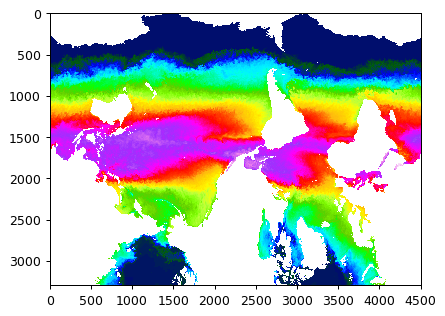

In [8]:
plt.figure(dpi = 90)         # open a new figure window and set the resolution
plt.imshow(sst, cmap = 'gist_ncar');

- This is how the model data is stored in the array.  The Latitude array is similarly upside down.


- Also note that the longitude values are a bit odd. 


In [9]:
print(sst.Longitude.min().data, sst.Longitude.max().data)

74.1199951171875 434.1199951171875


- In fact, the whole model grid is pretty weird.  It's called a tripolar grid.
<img src="/global/about/images/small/pic1.png">

- Now set up the figure and plot the SST field in a Mercator projection, using Cartopy to handle the projection details and letting xarray decide how to plot the data. The default for 2-D plotting is `pcolormesh()`.


- Xarray is very smart and will try to use a diverging (bicolor) colormap if the data values straddle zero.<br>
- You override this by specifying the colormap with `cmap=` and the `vmin=, vmax=` values for your data.


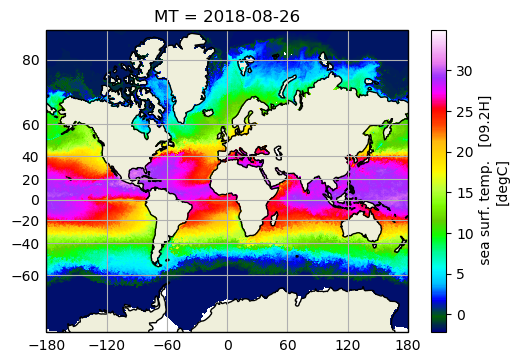

In [10]:
plt.figure(dpi = 100)
ax = plt.axes(projection = ccrs.Mercator())
ax.add_feature(cfeature.LAND)           # fill in the land areas
ax.coastlines()                         # use the default coastline
gl = ax.gridlines(draw_labels = True)   # default is to label all axes.
gl.xlabels_top = False                  # turn off two of them.
gl.ylabels_right = False

sst.plot(x = 'Longitude', y = 'Latitude', cmap = 'gist_ncar', 
         vmin = sst.min(), vmax=sst.max(),
         transform = ccrs.PlateCarree());


- Now let's concentrate on the waters around Hawaii (lat: 17 to 24, lon: -163 to -153)
 


- RTOFS longitudes are defined as 74-430, so we need to convert the -163 and -153 values by computing modulo 360.  Python uses the "%" operator for modulus math.



- Use the `object.where()` method with the lat/lon limits.


In [11]:
hawaii = sst.where((sst.Longitude >= -163%360) & 
                   (sst.Longitude <= -153%360) & 
                   (sst.Latitude >= 17) & 
                   (sst.Latitude <= 24), drop = True)


- Note the `drop = True` option, which instructs the `.where()` method to subset the data.
Otherwise it will retain the full array size and simply mask out the unwanted data.



- As before, let's plot the SST in a Mercator projection, but use a high-resolution coastline.
<br> 
- Since the water around Hawaii is warm I don't have to specify the colormap limits.


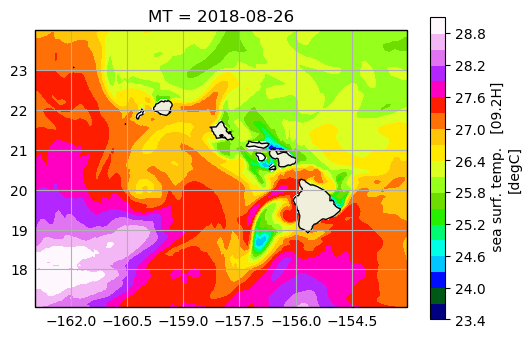

In [12]:
plt.figure(dpi = 100)
ax = plt.axes(projection = ccrs.Mercator())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.GSHHSFeature()) # use a high-resolution GSHHS coastline
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

hawaii.plot.contourf(x = 'Longitude',y = 'Latitude',levels = 20,
                     cmap = 'gist_ncar',add_colorbar = True,
                     transform = ccrs.PlateCarree());

## Next Example -- <a href="Python_tutorial_grib.slides.html">Reading a GRIB file</a>